<center>
<font size="6">Active learning and dimensionality reduction</font><br>
<font size="4">Fish classification and weight estimation</font>
    </center>

Project of course (FTE40306)Advanced Machine Learning
by Jialin He and George Truijens

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import pairwise_distances
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from numpy.linalg import svd
!pip install umap-learn
import umap
from sklearn.manifold import TSNE

# create a random seed to ensure reproducibility
general_seed=11
np.random.seed(general_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 487.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


We will load the data from a GIT repository. After running, the data will be availabe in the subdirectoy `data`.

In [2]:
!git clone https://git.wur.nl/manuel.cordovaneira/project_active_learning.git data

Cloning into 'data'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 60 (delta 9), reused 1 (delta 1), pack-reused 23 (from 1)
Receiving objects: 100% (60/60), 486.46 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (6/6), done.


In [3]:
# load data
all_features = np.load('data/crop_features/fish_features_all.npy')
pca_features = np.load('data/crop_features/fish_features_pca.npy')

# Part 0: Explore the data

In [4]:
#See how many samples there are, which columns contain the features and which contain the species and weight
print("shape of data, 512D:",all_features.shape)
print("shape of data, 2D:", pca_features.shape)
print("see the first 5 rows of the data, 2D:", pca_features[:5])

shape of data, 512D: (2216, 515)
shape of data, 2D: (2216, 5)
see the first 5 rows of the data, 2D: [['2021_02_25_den_helder_1000_rgb_0.png' '8.279625547021496'
  '-1.5020808359335853' '0' '0.091']
 ['2021_02_25_den_helder_1000_rgb_1.png' '5.898267760644868'
  '3.726218461466493' '0' '0.102']
 ['2021_02_25_den_helder_1002_rgb_0.png' '-7.400850478612387'
  '4.441324962381997' '0' '0.091']
 ['2021_02_25_den_helder_1002_rgb_1.png' '-6.411358705813361'
  '1.0837173362711328' '0' '0.149']
 ['2021_02_25_den_helder_1003_rgb_0.png' '-4.846385950431063'
  '0.568388817721724' '0' '0.083']]


There are 2216 samples. The first feature is the name of sample. The second and the third features are the PCA components, the fourth feature is the class of the fish, and the last feature is the weight of the fish.

In [5]:
# convert the data to a pandas dataframe
pd_pca_features = pd.DataFrame(pca_features)
pd_all_features= pd.DataFrame(all_features)
# remove the first column, which is the name of the sample
pd_pca_features = pd_pca_features.drop(0, axis=1)
pd_all_features = pd_all_features.drop(0, axis=1)
pd_pca_features.columns = ['PC1', 'PC2', 'species', 'weight']
# Rename the last two columns with correct names
pd_all_features.rename(columns={pd_all_features.columns[-2]: 'species', pd_all_features.columns[-1]: 'weight'}, inplace=True)
# check if the remaming is correct
print(pd_all_features)

                        1                    2                   3  \
0      3.0071191787719727  0.12603908777236938  0.6979246139526367   
1       0.386258989572525   1.1226427555084229  1.0435104370117188   
2     0.06126959249377251  0.12167169153690338  2.8853535652160645   
3      1.8087403774261475   0.4757564067840576  2.8627660274505615   
4      1.3359979391098022    3.465714454650879  0.2576068043708801   
...                   ...                  ...                 ...   
2211    0.279192179441452   1.1441231966018677   3.151153087615967   
2212                  0.0   1.3867559432983398  0.7566581964492798   
2213   0.4540766775608063   1.0061672925949097  1.1352001428604126   
2214  0.16958294808864594  0.39326784014701843  1.8234431743621826   
2215   0.1815354824066162  0.07490415126085281  2.7550792694091797   

                       4                   5                     6  \
0     0.5297664999961853  2.1939356327056885  0.015936175361275673   
1     0.59299522638

<Axes: ylabel='count'>

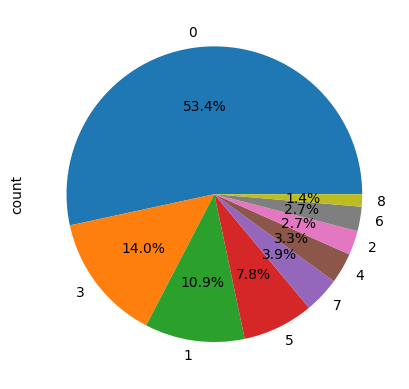

In [6]:
# make a pie chart of the species
species = pd_pca_features['species'].value_counts()
species.plot.pie(autopct='%1.1f%%')

In [7]:
# print the datatype of the columns, before correcting them
print(pd_pca_features.dtypes)
print(pd_all_features.dtypes)

PC1        object
PC2        object
species    object
weight     object
dtype: object
1          object
2          object
3          object
4          object
5          object
            ...  
510        object
511        object
512        object
species    object
weight     object
Length: 514, dtype: object


                 1            2            3            4            5  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean      0.668807     0.683324     1.713759     0.805913     0.792463   
std       0.752107     0.663596     1.209198     0.723109     0.605310   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.108792     0.172927     0.754602     0.220958     0.347295   
50%       0.434102     0.488583     1.541237     0.631667     0.673034   
75%       0.964736     1.015018     2.461598     1.219843     1.054928   
max       5.313149     4.415049     6.624347     3.973148     4.923722   

                 6            7            8            9           10  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean      0.232044     0.539233     0.794311     1.812431     0.704092  ...   
std       0.329823     0.589335     0.687153     1.236665     0.680798  ...   
min       0.00000

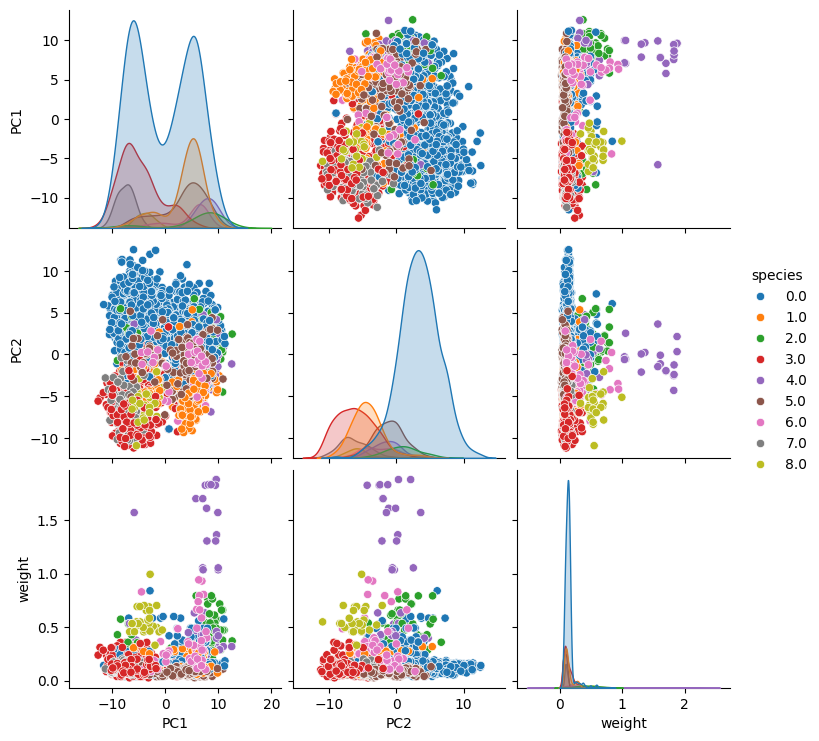

In [8]:
# convert all the data to float,except the species
pd_pca_features = pd_pca_features.astype(float)
pd_all_features = pd_all_features.astype(float)
pd_pca_features['species'] = pd_pca_features['species'].astype('category')
pd_all_features['species'] = pd_all_features['species'].astype('category')
# make the pairplot of 2D dataset
sns.pairplot(data=pd_pca_features, hue='species',vars=['PC1', 'PC2','weight'], diag_kind='kde')
# print the mean value and standard deviation of the features for the 512D dataset
print(pd_all_features.describe())

In [9]:
# apply standard scaling to the features, except the species and weight
scaler = StandardScaler()
pd_pca_features[['PC1', 'PC2']] = scaler.fit_transform(pd_pca_features[['PC1', 'PC2']])
pd_all_features.iloc[:, :-2] = scaler.fit_transform(pd_all_features.iloc[:, :-2])
# check the result of standard scaling
print(pd_pca_features)
print(pd_all_features)

           PC1       PC2 species  weight
0     1.382351 -0.310445     0.0   0.091
1     0.984764  0.770122     0.0   0.102
2    -1.235632  0.917918     0.0   0.091
3    -1.070429  0.223979     0.0   0.149
4    -0.809144  0.117473     0.0   0.083
...        ...       ...     ...     ...
2211 -0.263755 -0.427723     8.0   0.703
2212 -1.023989 -1.130938     8.0   0.535
2213 -1.037046 -1.352778     8.0   0.534
2214 -0.488037 -1.309146     8.0   0.657
2215 -0.489508 -1.439609     8.0   0.584

[2216 rows x 4 columns]
             1         2         3         4         5         6         7  \
0     3.109715 -0.839984 -0.840279 -0.381974  2.315819 -0.655372 -0.871354   
1    -0.375760  0.662177 -0.554417 -0.294514  0.198539 -0.365967 -0.383452   
2    -0.807963 -0.846567  0.969120  0.887274 -1.215629 -0.682905 -0.783527   
3     1.515994 -0.312862  0.950436  1.016480 -0.654149  1.145771 -0.140389   
4     0.887295  4.193843 -1.204502  0.902960 -0.998325  0.635451  1.402454   
...        ... 

In [10]:
# print the data type of each column,after correct conversion
print(pd_pca_features.dtypes)
print(pd_all_features.dtypes)

PC1         float64
PC2         float64
species    category
weight      float64
dtype: object
1           float64
2           float64
3           float64
4           float64
5           float64
             ...   
510         float64
511         float64
512         float64
species    category
weight      float64
Length: 514, dtype: object


# Part 1: Active learning for classification in 2 dimensions

## Define Commonly used functions

In [11]:
# define the commonly used operations
def get_features(df,columns_to_delete = ['species', 'weight']):
    return df.drop(columns=[col for col in columns_to_delete if col in df])
def get_label(df, name="species"):
    return df[name]

## 1.1: split data

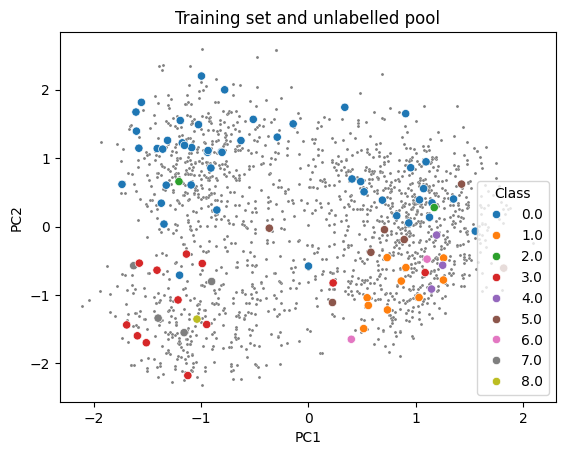

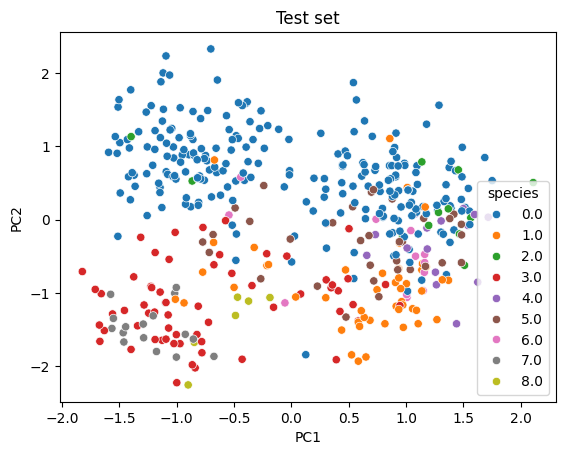

In [12]:
#Step 1: Split the data

#Define a function to split data into a initial training set, a unlabelled pool, and a test set.
def al_split_data(my_data, train_size, test_size):
    assert len(my_data) - train_size - test_size > 0
    # First split of a test set
    if(my_data.species.dtype.name == 'category'):
        my_data, test_data = train_test_split(my_data, test_size=test_size, stratify=my_data['species'])
    else:
        my_data, test_data = train_test_split(my_data, test_size=test_size)
    # Then split of a small training set and leave the rest in the unlabelled pool
    if(my_data.species.dtype.name == 'category'):
        train_data, unlabelled_data = train_test_split(my_data, train_size=train_size, stratify=my_data['species'])
    else:
        train_data, unlabelled_data = train_test_split(my_data, train_size=train_size)

    train_data.reset_index(drop=True, inplace=True)
    unlabelled_data.reset_index(drop=True, inplace=True)

    return train_data, unlabelled_data, test_data

#Split the data with the function
train_data, unlabelled_data, test_data = al_split_data(pd_pca_features,train_size= 0.05, test_size=0.20) #train_size=100, test_size=500, in exact numbers
dev_data=pd.concat([train_data,unlabelled_data],axis=0)
data_list = ['train_data', 'unlabelled_data', 'test_data','dev_data']

# Loop over the data variables to get features and labels
for data_name in data_list:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")

# Visualize the results
sns.scatterplot(data=unlabelled_data, x='PC1', y='PC2', color='gray', s=5)
sns.scatterplot(data=train_data, x='PC1', y='PC2', hue='species')
plt.title('Training set and unlabelled pool')
plt.legend(loc='lower right',title='Class')
plt.show()
sns.scatterplot(data=test_data, x='PC1', y='PC2', hue='species')
plt.title('Test set')
plt.show()

## 1.2 : train classifier

Prediction on training 
data accuracy: 0.708803611738149,
recall:0.708803611738149,
precision:0.708803611738149,
f1 macro: 0.23891491356433628,
f1 micro: 0.708803611738149 


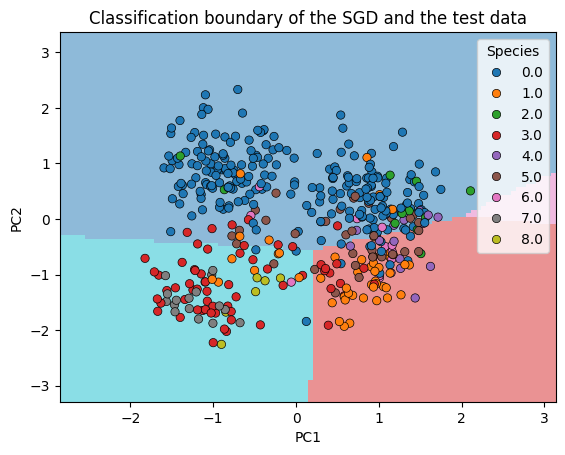

In [13]:
#Step 2: Train a classifier

#Define a function to plot the decisionboundary
def plotClassificationOutput2D_AL(clf, data, unlabelled_data=None, selected_data=None):
    if(unlabelled_data is not None):
        data_X = pd.concat([data[['PC1','PC2']],unlabelled_data[['PC1','PC2']]])
    else:
        data_X =get_features(data)


    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf, data_X, cmap='tab10', alpha=0.5, ax=ax,
        response_method="predict", plot_method="pcolormesh",
        xlabel='PC1', ylabel='PC2', shading="auto",
    )

    sns.scatterplot(data=data, x='PC1', y='PC2', hue='species', palette='tab10', alpha=1.0, edgecolor="black")
    plt.legend(title='Species', facecolor='white', frameon=True)
    if(unlabelled_data is not None):
        sns.scatterplot(data=unlabelled_data, x='PC1', y='PC2', color='black', s=8)
    if(selected_data is not None):
        sns.scatterplot(data=selected_data, x='PC1', y='PC2', color='white', s=30, alpha=1.0, edgecolor="white", linewidth=1, legend=False)

# Train a classifier
model = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model.fit(dev_data_X, dev_data_y)

#Print different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_y, model.predict(dev_data_X)),
precision_score(dev_data_y, model.predict(dev_data_X),average='micro'),
recall_score(dev_data_y, model.predict(dev_data_X),average='micro'),
f1_score(dev_data_y, model.predict(dev_data_X), average ='macro'),
f1_score(dev_data_y, model.predict(dev_data_X), average ='micro')))
# Plot the classification boundary of the SGD and the test data
plotClassificationOutput2D_AL(model, test_data)
plt.title('Classification boundary of the SGD and the test data')
plt.show()

## 1.3 random sampling

In [14]:
#Step 3: A function that randomly samples from the data
def al_sampling_random(unlabelled_data, n_samples):
    assert len(unlabelled_data) >  n_samples
    sample_idx = np.random.choice(len(unlabelled_data), n_samples)  # Random set of samples
    unlabelled_sample = unlabelled_data.iloc[sample_idx,:]          # Get the samples
    return unlabelled_sample, sample_idx, None

## 1.4 Iterative Active Learning

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


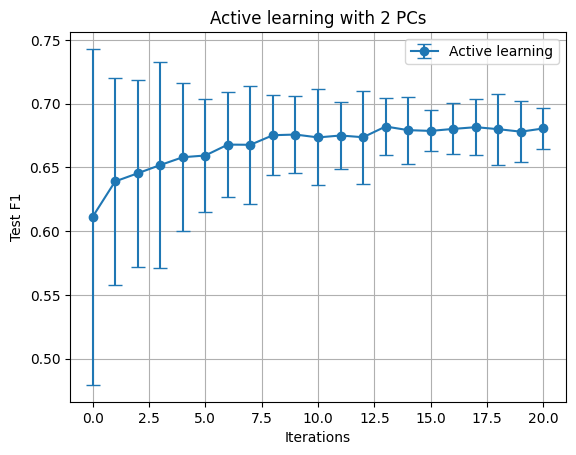

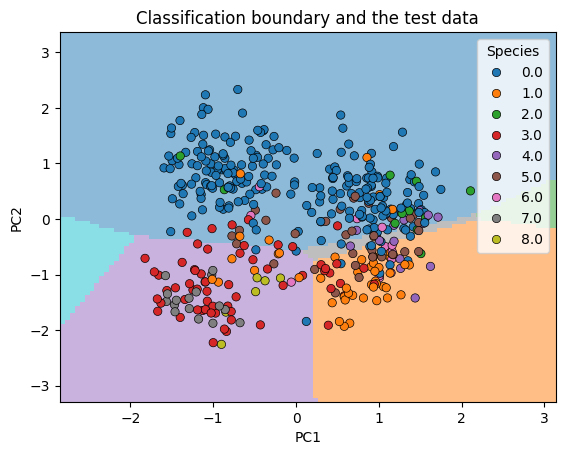

Test accuracy: 0.6869369369369369


In [15]:
#Step 4: Iterative Active learning

#-----------------------------------------Metric support functions-----------------------------------------
# Function calculation diversity for most-diverse sampling

def get_div_knn(clf, data, C):
    X = get_features(data)
    dist, _ = clf.kneighbors(X)        # 1. Get the distance to all k neighbors for all samples X
    dist_mean = np.mean(dist, axis=1)  # 2. Get the mean distance to the neighbors per sample
    div = dist_mean / dist_mean.max()  # 3. Normalize the distances from 0 to 1
    return div

def get_div_sgd(clf, data, C):
    X = get_features(data)
    distances = pairwise_distances(X)  # 1. Compute pairwise distances among all samples
    dist_mean = np.mean(distances, axis=1)  # 2. Get the mean distance to all other samples for each sample
    div = dist_mean / dist_mean.max()  # 3. Normalize the distances from 0 to 1
    return div

## Function calculating uncertainty for Least-certainty sampling
def get_unc_lc(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples
    unc = (1 - pred_prob.max(axis=1))*C/(C-1)      # 2.Calculate the uncertainty
    return unc


## Function calculating the performance of the classifier. Different metrics can be selected.
def getPerformance(clf, data, metric = "f1_micro", name = "species"):
    # F1, to deal with imbalanced data set
    # micro, to take the class distribution of dataset into account
    data_X, data_y = get_features(data), get_label(data,name = name)
    pred_y = clf.predict(data_X)
    if name == "weight":
        performance = mean_squared_error(data_y, pred_y)
    else:
        if metric == "f1_macro":
            performance = f1_score(data_y,pred_y, average = "macro")
        elif metric == 'f1_micro':
            performance = f1_score(data_y,pred_y, average = "micro")
        elif metric == 'acc':
            performance = accuracy_score(data_y, pred_y)

    return(performance)


#-----------------------------------------Active learning functions-----------------------------------------

#Function to add the sampled data to the train_data pool
def al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx):
    # Add the sample to the training data

    train_data = pd.concat([train_data, unlabelled_sample])
    train_data.reset_index(drop=True, inplace=True)
    # Remove the sample from the unlabelled data
    unlabelled_data.drop(sample_idx, inplace=True)
    unlabelled_data.reset_index(drop=True, inplace=True)
    return train_data, unlabelled_data


#Function to train a machine learning classifier and test it on the test_data
def al_train_and_test(clf, train_data, test_data, show=False, name = "species"):
    train_X,train_y=get_features(train_data),get_label(train_data, name)#train_data['species']
    clf.fit(train_X, train_y)

    if(show):
        # Plot the classification boundary and the test data
        plotClassificationOutput2D_AL(clf, test_data)
        plt.title('Classification boundary and the test data')
        plt.show()

    # Get the performance
    if name == "species":
        test_acc = getPerformance(clf, test_data)
    elif name == "weight":
        test_acc = getPerformance(clf, test_data, metric = "acc", name = "weight")
    return(test_acc)

#Function to sample new data from the unlabbeled data pool based on uncertainty
def al_sampling_unc(clf, sample_score_fnc, unlabelled_data, n_samples, name = "species"):
    n = min(n_samples, len(unlabelled_data))
    if(n>0):
        unc = sample_score_fnc(clf, unlabelled_data, C=len(clf.classes_) if name == "species" else None)
        sort_idx = np.argsort(unc, )[::-1]                # 3.Sort samples in descending order based on uncertainty
        t5_idx = sort_idx[0:n]                              # 4.Select the top 5 most uncertain samples
        unlabelled_sample = unlabelled_data.iloc[t5_idx,:]  # 5.Get the sample
        return unlabelled_sample, t5_idx, unc[t5_idx]
    else:
        return None,None,None

#Function to run the active learning pipeline
def run_al(sample_score_fnc, clf, train_data0, unlabelled_data0, test_data0, n_samples, N, combine = False, name = "species" ):
    test_accuracy = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_acc = al_train_and_test(clf, train_data, test_data, show=False, name = name)
    test_accuracy.append(test_acc)
    for it in range(N):
        if combine:
            #Uncertainty sampling and training on 1/2 data
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples // 2, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)
            #Diversity sampling and training on other 1/2 data
            unlabelled_sample, sample_idx, sample_div = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples // 2, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)
        else:
            #Uncertainty sampling and training
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)

        test_acc = al_train_and_test(clf,train_data,test_data, name = name)

        test_accuracy.append(test_acc)
    return(test_accuracy, train_data, unlabelled_data)

def mean_std(data):
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mean, std


sample_factor = 0.05
N = int(1/sample_factor) #number of iterations of active learning
n_samples = int(unlabelled_data.shape[0]*sample_factor) #number of samples to take at every iteration
model = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')

test_performance_al = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_performance_al.append(test_accuracy_al)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)

# Plotting with confidence intervals
ci = 1.96 * std_lc

plt.errorbar(range(N+1), mean_lc, yerr=ci, fmt='o-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Active learning with 2 PCs')
plt.legend(['Active learning'])
plt.grid()
plt.show()

#Calculating the performance with the newest training set
test_acc = al_train_and_test(model, train_data_al, test_data, show=True)
print("Test accuracy:", test_acc)

## 1.5 Compare with random sampling

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


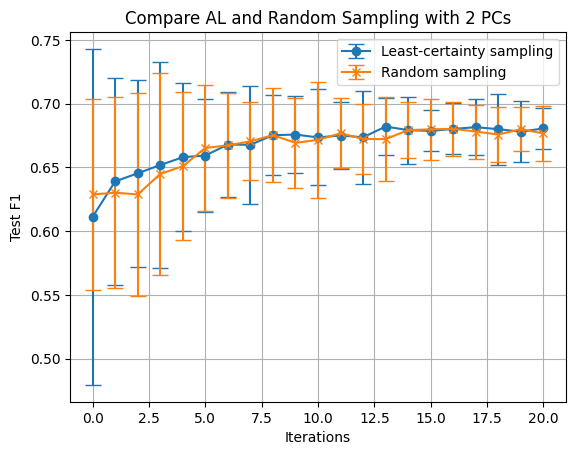

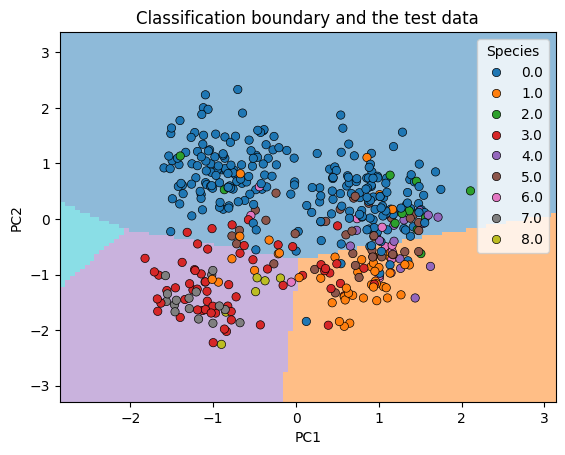

Test accuracy: 0.6914414414414415


In [16]:
#Step 5: Compare with the random sampling method

def al_sampling_random(unlabelled_data, n_samples):
    assert len(unlabelled_data) >  n_samples
    sample_idx = np.random.choice(len(unlabelled_data), n_samples)  # Random set of samples
    unlabelled_sample = unlabelled_data.iloc[sample_idx,:]          # Get the samples
    return unlabelled_sample, sample_idx, None

# Random learning
def run_random(clf, train_data0, unlabelled_data0, test_data0, n_samples, N):
    test_accuracy = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_acc = al_train_and_test(clf, train_data, test_data, show=False)
    test_accuracy.append(test_acc)
    for it in range(N):
        unlabelled_sample, sample_idx, sample_unc = al_sampling_random(unlabelled_data, n_samples)
        train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)

        test_acc = al_train_and_test(clf, train_data, test_data, show=False)
        test_accuracy.append(test_acc)
    return(test_accuracy, train_data, unlabelled_data)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model, train_data, unlabelled_data, test_data, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=6)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=6)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Compare AL and Random Sampling with 2 PCs')
plt.legend(['Least-certainty sampling','Random sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc = al_train_and_test(model, train_data_al, test_data, show=True)
print("Test accuracy:", test_acc)

## 1.6 Compare different methods of Uncertainty Sampling

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


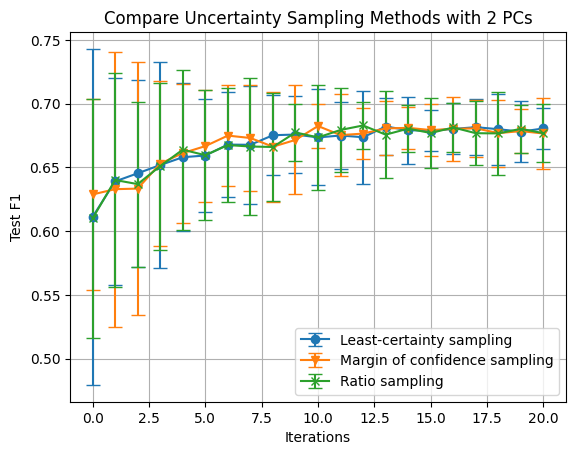

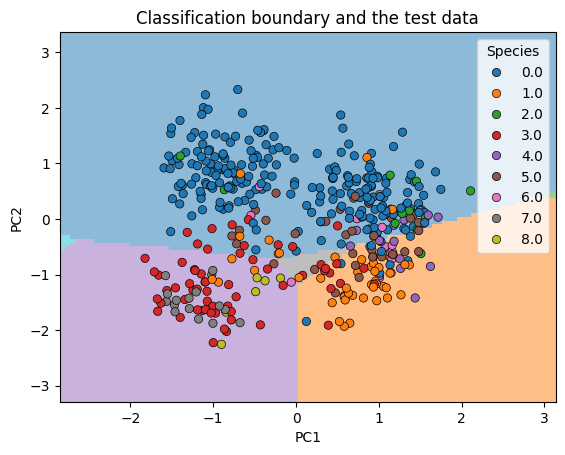

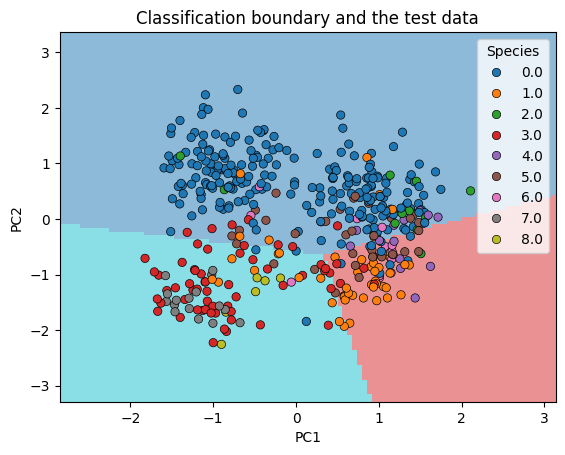

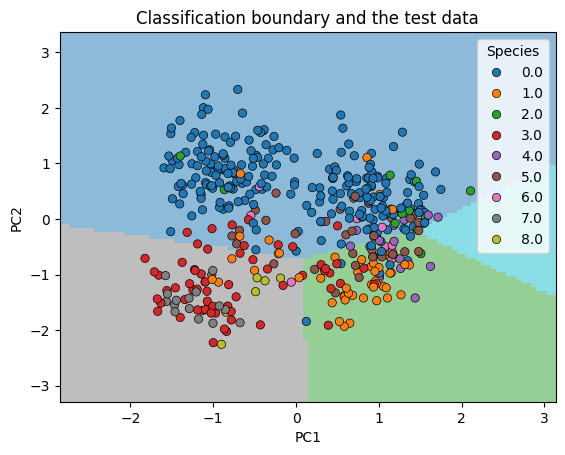

Test accuracy for lc: 0.6756756756756757, mc: 0.6869369369369369, rs 0.6846846846846847


In [17]:
#Step 6: Compare different methods of uncertainty sampling (NOT WORKING :())

## Function calculating uncertainty for Margin of confidence sampling
def get_unc_mc(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples
    p_sorted = np.sort(pred_prob, axis=1)[:,::-1]  # 2. Sort the probabilities per row in decending order
    unc = 1 - (p_sorted[:,0] - p_sorted[:,1])      # 3.Calculate the uncertainty
    return unc

## Function calculating uncertainty for Ratio sampling
def get_unc_rs(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples
    p_sorted = np.sort(pred_prob, axis=1)[:,::-1]  # 2. Sort the probabilities per row in decending order
    unc = p_sorted[:,1] / p_sorted[:,0]            # 3.Calculate the uncertainty
    return unc

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Compare Uncertainty Sampling Methods with 2 PCs')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model, train_data_al_lc, test_data, show=True)
test_acc_mc = al_train_and_test(model, train_data_al_mc, test_data, show=True)
test_acc_rs = al_train_and_test(model, train_data_al_rs, test_data, show=True)
print("Test accuracy for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

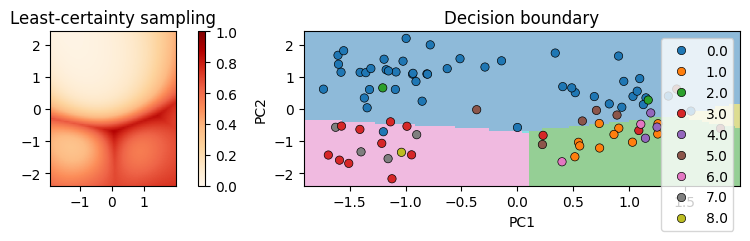

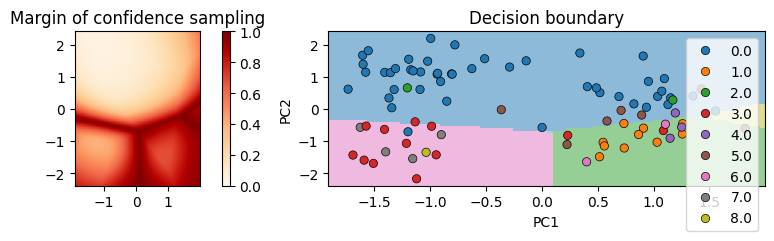

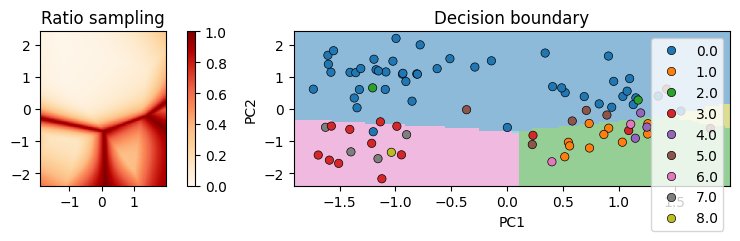

In [18]:
# Plotting the uncertainty
def plotSampleScore(sample_score_fnc, clf, X, title):
    x1min, x1max = X['PC1'].min(), X['PC1'].max()
    x2min, x2max = X['PC2'].min(), X['PC2'].max()
    x1range, x2range = x1max-x1min, x2max-x2min
    x1min, x1max = x1min - 0.05*x1range, x1max + 0.05*x1range
    x2min, x2max = x2min - 0.05*x2range, x2max + 0.05*x2range

    n=100
    x1, x2 = np.meshgrid(np.linspace(x1min,x1max,n), np.linspace(x2min,x2max,n))
    pts = np.array([x1.flatten(),x2.flatten()]).T
    test_data = pd.DataFrame({'PC1':pts[:,0], 'PC2':pts[:,1]})
    unc = sample_score_fnc(clf, test_data, C=len(clf.classes_))
    unc_mat = unc.reshape(x1.shape)

    # Plot the uncertainty map and the decision boundary
    fig, axs = plt.subplots(1,2,figsize=(10,2.5))
    im = axs[0].imshow(unc_mat, extent=[x1min, x1max, x2min, x2max],origin='lower',cmap='OrRd',vmin=0,vmax=1)
    axs[0].set_title(title)
    plt.colorbar(im,ax=axs[0], fraction=0.022)
    DecisionBoundaryDisplay.from_estimator(
        clf, test_data[['PC1','PC2']], cmap='tab10', alpha=0.5, ax=axs[1],
        response_method="predict", plot_method="pcolormesh",
        xlabel='PC1', ylabel='PC2', shading="auto"
    )
    sns.scatterplot(data=X, x='PC1', y='PC2', hue='species', palette='tab10', alpha=1.0, ax=axs[1], edgecolor="black")
    axs[1].set_title('Decision boundary')
    axs[1].set_xlim([x1min, x1max])
    axs[1].set_ylim([x2min, x2max])
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

# Plot the uncertainty maps for the three methods
plotSampleScore(get_unc_lc, model, train_data, title='Least-certainty sampling')
plotSampleScore(get_unc_mc, model, train_data, title='Margin of confidence sampling')
plotSampleScore(get_unc_rs, model, train_data, title='Ratio sampling')

## 1.7 Compare uncertainty and diversity sampling

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


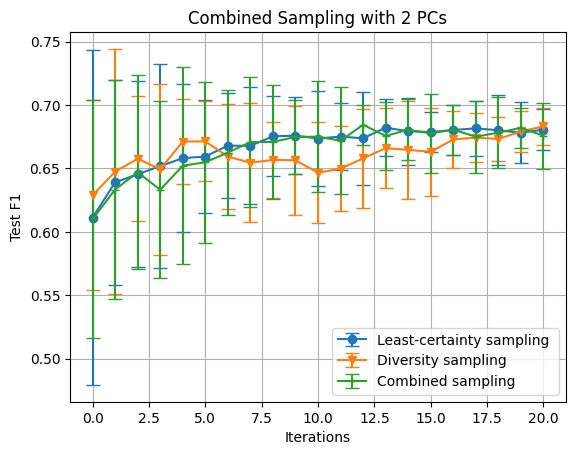

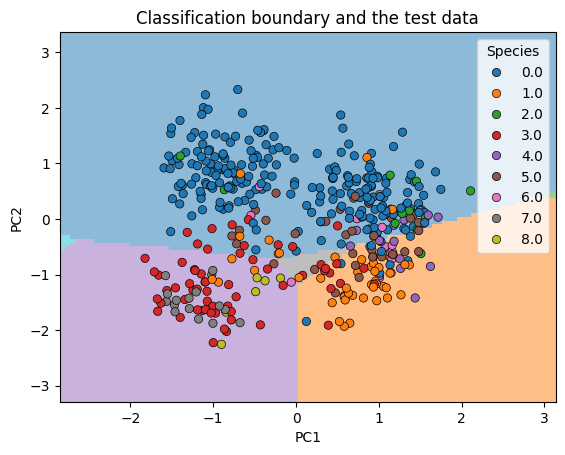

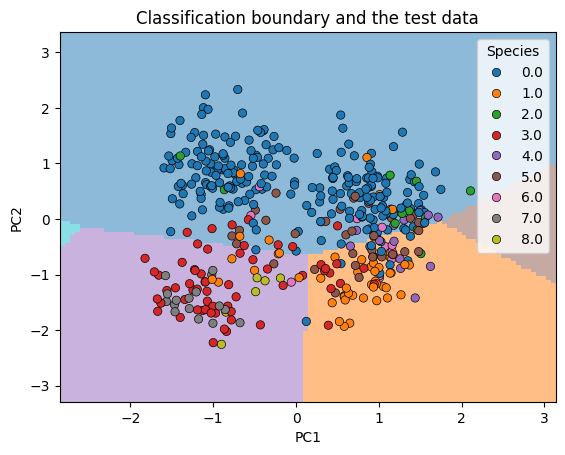

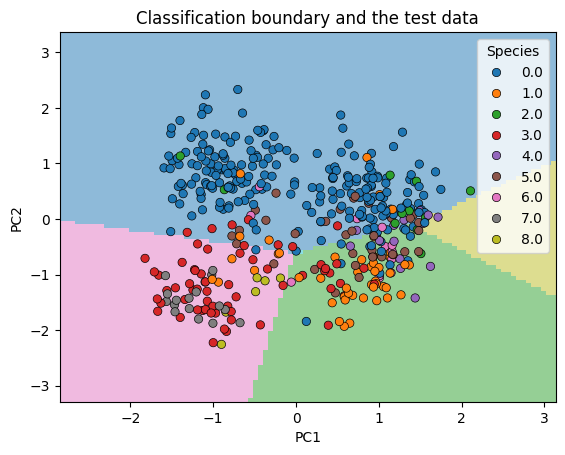

Test F1 Macro for lc: 0.6756756756756757, div: 0.6824324324324325, mix: 0.6779279279279279


In [19]:
#Step 7 Compare uncertainty and diversity sampling
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix= []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model, train_data, unlabelled_data, test_data, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model, train_data, unlabelled_data, test_data, n_samples, N, combine = True)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_div = 1.96 * std_div
ci_mix = 1.96 * std_mix

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=ci_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=ci_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling with 2 PCs')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()


#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model, train_data_al_lc, test_data, show=True)
test_acc_div = al_train_and_test(model, train_data_al_div, test_data, show=True)
test_acc_mix = al_train_and_test(model, train_data_al_mix, test_data, show=True)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))

# Part 2: Active learning for classification in 512 dimensions

## 2.1 Prepare data

In [20]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")


## 2.2 Train a classifier with all data

In [21]:
#Step 2: Train the classifier with all data
#Train a classifier
model_all = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model_all.fit(dev_data_all_X, dev_data_all_y)
#Print the different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_all_y, model_all.predict(dev_data_all_X)),
precision_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
recall_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='macro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='micro')))

Prediction on training 
data accuracy: 0.9971783295711061,
recall:0.9971783295711061,
precision:0.9971783295711061,
f1 macro: 0.9956132520250883,
f1 micro: 0.9971783295711061 


## 2.3 Random sampling(skipped)

## 2.4 Iterative active learning(skipped)

## 2.5  Compare random sampling

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


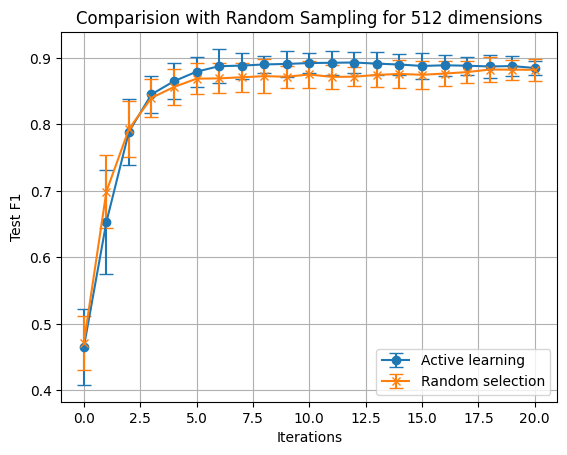

Test F1 Macro for lc: 0.8941441441441441, rand: [0.5045045045045045, 0.7297297297297297, 0.8018018018018018, 0.8288288288288288, 0.8468468468468469, 0.8558558558558559, 0.8716216216216216, 0.8783783783783784, 0.8783783783783784, 0.8693693693693695, 0.8828828828828829, 0.8783783783783784, 0.8783783783783784, 0.8783783783783784, 0.8716216216216216, 0.8828828828828829, 0.8873873873873874, 0.8873873873873874, 0.8963963963963963, 0.8851351351351351, 0.8851351351351351]


In [22]:
#Step 3 skip
#Step 4 itterative active learning
#Step 5: Compare least uncertainty sampling with random sampling
np.seterr(divide='ignore', invalid='ignore')

sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=5)
plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Random Sampling for 512 dimensions')
plt.legend(['Active learning','Random selection'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al, test_data_all, show=False)
print("Test F1 Macro for lc: {}, rand: {}".format(test_acc_lc, test_accuracy_rand ))


## 2.6 Compare different uncertainty sampling methods

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19
seed: 20
seed: 21
seed: 22
seed: 23
seed: 24
seed: 25
seed: 26
seed: 27
seed: 28
seed: 29


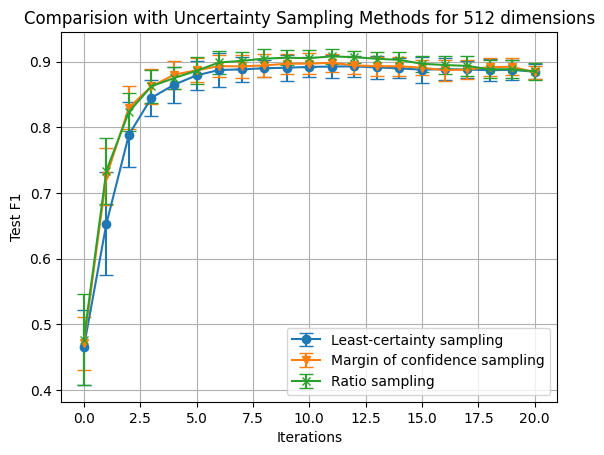

Test F1 Macro for lc: 0.8896396396396397, mc: 0.8806306306306307, rs 0.8896396396396397


In [23]:
#Step 6: Compare the different types of uncertainty sampling

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Uncertainty Sampling Methods for 512 dimensions')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_mc = al_train_and_test(model_all, train_data_al_mc, test_data_all, show=False)
test_acc_rs = al_train_and_test(model_all, train_data_al_rs, test_data_all, show=False)
print("Test F1 Macro for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

## 2.7 Compare uncertainty and diversity sampling

In [24]:
#Step 7 Compare uncertainty and diversity sampling
np.seterr(divide='ignore', invalid='ignore')
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed: ",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N, combine = True)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)


seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29


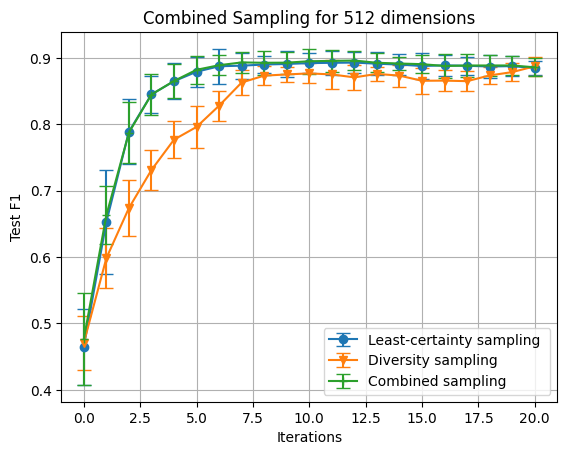

Test F1 Macro for lc: 0.8896396396396397, div: 0.8873873873873874, mix: 0.9054054054054054


In [25]:
#del test_accuracy_al_lc, train_data_al_lc, _  # Clear variables after use
#del test_accuracy_al_div, train_data_al_div # Clear variables after use
#del test_accuracy_al_mix, train_data_al_mix # Clear variables after use

#print(test_performance_lc.shape)
#Calculate the mean and standard deviation of the data
test_performance_lc = np.vstack(test_performance_lc)
test_performance_div = np.vstack(test_performance_div)
test_performance_mix = np.vstack(test_performance_mix)


mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%

plt.errorbar(range(N+1), mean_lc, yerr=1.96 * std_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=1.96 * std_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=1.96 * std_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling for 512 dimensions')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_div = al_train_and_test(model_all, train_data_al_div, test_data_all, show=False)
test_acc_mix = al_train_and_test(model_all, train_data_al_mix, test_data_all, show=False)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))

# Part 3: Dimensionality reduction and active learning

Note that the test set should not be used during the dimensionality reduction process.

## 3.1 Kernel PCA

<ipython-input-26-1397539450b2>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter= plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=dev_data_all_y, cmap=plt.cm.get_cmap('Paired'))


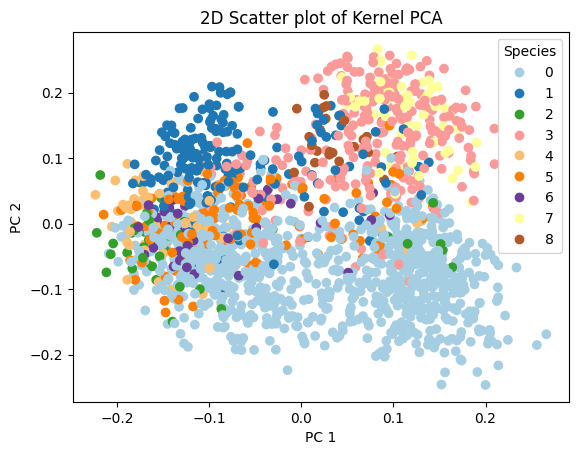

In [26]:
# Apply Kernel PCA
n_features= 512
kpca = KernelPCA(n_components=2, kernel='rbf',gamma=1/n_features*0.1)
X_kpca = kpca.fit_transform(dev_data_all_X)
scatter= plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=dev_data_all_y, cmap=plt.cm.get_cmap('Paired'))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("2D Scatter plot of Kernel PCA")
# add a legend using the labels of data
plt.legend(*scatter.legend_elements(), title="Species")
plt.show()

<ipython-input-27-6a04209070cb>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = ax.scatter(X_kpca_3d[:, 0], X_kpca_3d[:, 1], X_kpca_3d[:, 2], c=dev_data_all_y, cmap=plt.cm.get_cmap('Paired'))


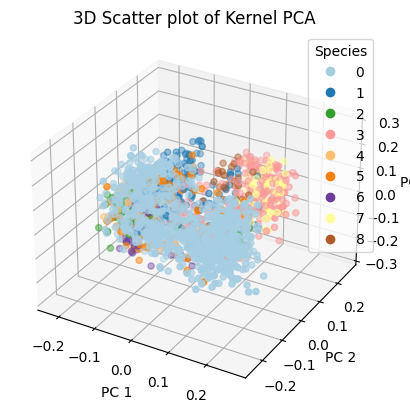

In [27]:
kpca_3d= KernelPCA(n_components=3, kernel='rbf', gamma=1/n_features*0.1)
X_kpca_3d = kpca_3d.fit_transform(dev_data_all_X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_kpca_3d[:, 0], X_kpca_3d[:, 1], X_kpca_3d[:, 2], c=dev_data_all_y, cmap=plt.cm.get_cmap('Paired'))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D Scatter plot of Kernel PCA')
plt.legend(*scatter.legend_elements(), title="Species")
plt.show()

In [28]:
# k-nearst neighbors using the 3 principal components

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_kpca_3d, dev_data_all_y)
test_X = kpca_3d.transform(test_data_all_X)
y_pred_knn_kpca_3d = knn.predict(test_X)
print('Accuracy:', accuracy_score(test_data_all_y, y_pred_knn_kpca_3d))
print('Precision:', precision_score(test_data_all_y, y_pred_knn_kpca_3d, average='weighted'))
print('Recall:', recall_score(test_data_all_y, y_pred_knn_kpca_3d, average='weighted'))
# F1 micro and F1 macro
print('F1 micro:', f1_score(test_data_all_y, y_pred_knn_kpca_3d, average='micro'))
print('F1 macro:', f1_score(test_data_all_y, y_pred_knn_kpca_3d, average='macro'))

Accuracy: 0.7319819819819819
Precision: 0.6976033918203304
Recall: 0.7319819819819819
F1 micro: 0.7319819819819819
F1 macro: 0.44479000395286544


## 3.2 t-SNE

Note that tSNE is transductive. A transductive (contrasted with inductive) machine learning method is designed to model a specific dataset, but not to apply that model to unseen data. Examples include manifold.TSNE, cluster.AgglomerativeClustering and neighbors.LocalOutlierFactor. https://scikit-learn.org/stable/glossary.html#term-transductive

Therefore, we can not measure the effectiveness of t-SNE in terms of improving predictive power.

In [29]:

#Step Extract a t-SNE representation from the development data
X_labels = get_label(dev_data_all)
np.random.seed(general_seed)
n_components = 2
tsne = TSNE(n_components, perplexity=30, n_iter=5000,random_state=general_seed)
X_tsne = tsne.fit_transform(dev_data_all_X)
print(X_tsne.shape)

(1772, 2)


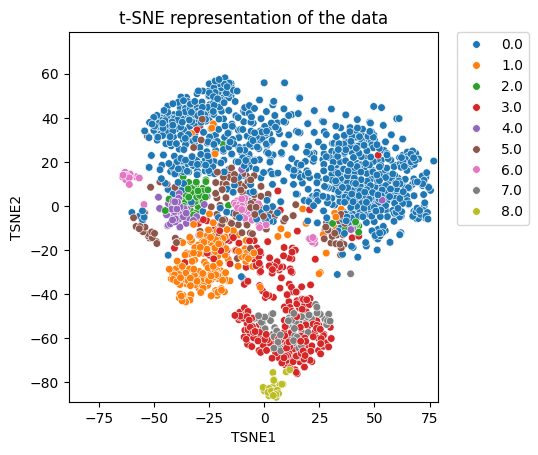

In [30]:
#Visualize the t-SNE representation
X_tsne_df = pd.DataFrame({'TSNE1': X_tsne[:,0], 'TSNE2': X_tsne[:,1], 'label': X_labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=X_tsne_df, ax=ax, s=30)
lim = (X_tsne.min()-2, X_tsne.max()+2)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.set_title("t-SNE representation of the data")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## 3.3 UMAP

In [31]:
#Extract a UMAP representation from the development data with the help of a PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(dev_data_all_X)
reducer = umap.UMAP(metric="euclidean", min_dist=0.1, n_neighbors=5,random_state=general_seed)
embedding = reducer.fit_transform(pca_result)
print(embedding.shape)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(1772, 2)


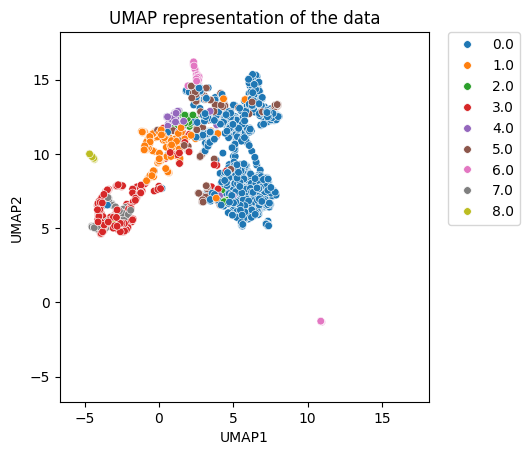

In [32]:
#Visualize the UMAP representation
umap_result_df = pd.DataFrame({'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'label': get_label(dev_data_all)})
fig, ax = plt.subplots(1)
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', data=umap_result_df, ax=ax, s=30)
lim = (embedding.min()-2, embedding.max()+2)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_title("UMAP representation of the data")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [33]:
#Train & Test UMaps representation on a KNN classifier
knn_u = KNeighborsClassifier(n_neighbors=5)
knn_u.fit(embedding, dev_data_all_y)

test_pca_result = pca.transform(test_data_all_X)
test_embedding = reducer.transform(test_pca_result)
y_pred_knn_u = knn_u.predict(test_embedding)
print('Accuracy:', accuracy_score(test_data_all_y, y_pred_knn_u))
print('Precision:', precision_score(test_data_all_y, y_pred_knn_u, average='weighted'))
print('Recall:', recall_score(test_data_all_y, y_pred_knn_u, average='weighted'))
# F1 micro and F1 macro
print('F1 micro:', f1_score(test_data_all_y, y_pred_knn_u, average='micro'))
print('F1 macro:', f1_score(test_data_all_y, y_pred_knn_u, average='macro'))

Accuracy: 0.8603603603603603
Precision: 0.8546097934063631
Recall: 0.8603603603603603
F1 micro: 0.8603603603603603
F1 macro: 0.7599246046903076


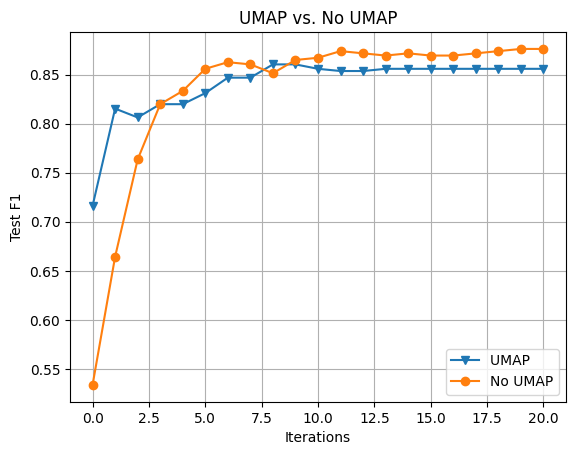

Test F1 Macro for UMAP: 0.8558558558558559, No UMAP: 0.8761261261261262


In [34]:
#Apply active learning using the dimensionality reduction method UMAP

data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels

for data_name in data_list_all:
    # Access variables dynamically using globals()
    X_data = globals()[f"{data_name}_X"]
    label = globals()[f"{data_name}_y"]

    # Perform PCA transformation
    pca_al = pca.transform(X_data)

    # Perform further reduction
    emb = reducer.transform(pca_al)

    # Convert embeddings and labels to DataFrames and reset their indices
    emb_df = pd.DataFrame(emb).reset_index(drop=True)
    label_df = pd.Series(label).reset_index(drop=True)

    # Concatenate embeddings and labels
    result_df = pd.concat([emb_df, label_df], axis=1)

    # Save the result back to a dynamically named variable
    globals()[f"{data_name}_emb"] = result_df

knn_u_al = KNeighborsClassifier(n_neighbors=5)
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_accuracy_al_emb, train_data_al_emb, _ = run_al(get_unc_lc, knn_u_al, train_data_all_emb, unlabelled_data_all_emb, test_data_all_emb, n_samples, N)
test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, knn_u_al, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

# PLOT THE RESULTS
plt.plot(range(N+1), test_accuracy_al_emb, marker = 'v')
plt.plot(range(N+1),test_accuracy_al_lc, marker = 'o')

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('UMAP vs. No UMAP')
plt.legend(['UMAP ','No UMAP'])
plt.grid()
plt.show()

test_acc_emb = al_train_and_test(knn_u_al, train_data_al_emb, test_data_all_emb, show=False)
test_acc_lc = al_train_and_test(knn_u_al, train_data_al_lc, test_data_all, show=False)
print("Test F1 Macro for UMAP: {}, No UMAP: {}".format(test_acc_emb, test_acc_lc ))

# Part 4: Dimensionality reduction and active learning using autoencoders (bonus)

## 4.0 SVD

[298.48173909 279.38898579 223.59823202 201.28260619 185.99279422
 175.1998868  164.25635745 148.01041043 133.77460067 132.23524761
 129.9568585  126.67409327 120.92764    116.58181587 115.55414743
 111.26281754 107.22180956 106.19136928 105.34744755 101.8449487
  99.21669094  98.12181123  95.33652933  94.98504991  92.00266066
  90.94702293  87.61181176  86.82352248  84.86461385  83.56577267
  82.30167055  80.92360043  80.11396621  78.6413474   77.86331413
  76.99670704  75.76901043  74.63242153  73.72688065  73.67773292
  71.96357233  71.34436112  69.76765771  69.42408537  68.55902279
  68.0001423   67.60439066  66.97687015  66.35037878  65.92933401
  65.06677746  64.83599101  64.08049924  63.31544628  62.94955198
  62.34257212  61.89787255  61.06115347  60.61490597  59.73887175
  59.51144137  59.01634559  58.01644546  57.90087271  57.25880876
  57.15903317  56.55851118  56.16817294  55.70791544  55.39978499
  55.05620599  54.45527412  53.8887903   53.70055956  53.06248304
  52.652871

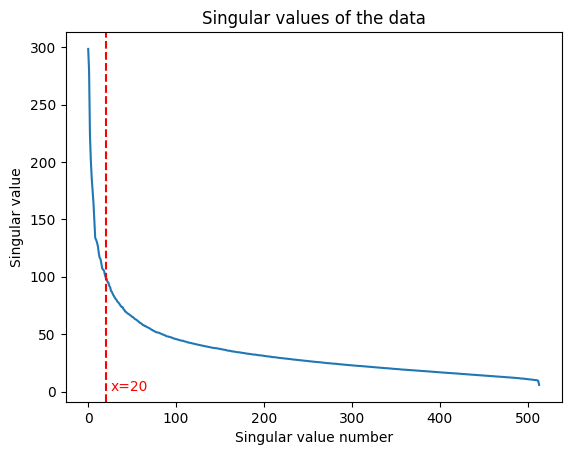

In [35]:
# use SVD(Singular value decomposition) to have a rough idea about the size of latent space in autoencoders
# decompose the 512D data with SVD, and see the number of non-trivial singular values
U, S, VT = svd(pd_all_features , full_matrices=False)
print(S)
plt.plot(S)
plt.axvline(x=20, color='r', linestyle='--')
plt.text(25, 1, 'x=20', color = 'r')
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.title('Singular values of the data')
plt.show()

## README

To keep this notebook neat, for the dimension reduction with autoencoders, see the other notebooks provided:
For Dimension Reduction:

For Performance Evaluation:

# Part 5: Active learning for regression (bonus)

## 5.1 Compare active learning and random sampling

In [36]:
#For uncertainty sampling, we need a regression method that provides information about the
#certainty. As done in the active-learning tutorial, you can use random-forest regression for this

def get_unc_sgd(clf, data):
    X = get_features(data)
    preds = np.array([clf.predict(X) for _ in range(10)])  # Get multiple predictions
    preds_std = np.std(preds, axis=0)  # Calculate the standard deviation of the predictions
    return preds_std / preds_std.max()  # Normalize the uncertainties

#Predict with RF on data to get a mean and variance
def predict_rf(rf, X):
    if isinstance(X, pd.DataFrame): #Makes sure the features are a numpy array
        X = X.to_numpy()
    y_pred_per_tree = np.array([tree.predict(X) for tree in rf.estimators_]) #Get the prediction of every tree
    pred_mean = y_pred_per_tree.mean(axis=0) #Calculate the mean
    pred_var = y_pred_per_tree.var(axis=0) #Calculate the variance
    return pred_mean, pred_var

#Get the uncertainty
def get_unc_rf(rf, data):
    X = get_features(data) #Get the features
    _,unc = predict_rf(rf, X) #Predict on the features and get variance
    return unc

#Function to calculate the mean squared error as performance metric
def getMSE(rf, data):
    data_X, data_y = get_features(data), get_label(data, name = "weight")
    pred_y = rf.predict(data_X)
    acc = mean_squared_error(data_y, pred_y)
    return(acc)

def get_div_rf(rf, data):
    X = get_features(data)
    distances = pairwise_distances(X)  # 1. Compute pairwise distances among all samples
    dist_mean = np.mean(distances, axis=1)  # 2. Get the mean distance to all other samples for each sample
    div = dist_mean / dist_mean.max()  # 3. Normalize the distances from 0 to 1
    return div

def al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx):
    # Add the sample to the training data

    train_data = pd.concat([train_data, unlabelled_sample])
    train_data.reset_index(drop=True, inplace=True)
    # Remove the sample from the unlabelled data
    unlabelled_data.drop(sample_idx, inplace=True)
    unlabelled_data.reset_index(drop=True, inplace=True)
    return train_data, unlabelled_data

In [37]:
#The relationship between image features and weight might be very different among species.
#Therefore, start with a subset of the data, taking only the samples of one species. Choose the
#species for which the full dataset has most samples. Split again in a test set and a
#training/development set.

pd_features_reg = pd_all_features[pd_all_features["species"] == 0]

train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg = al_split_data(pd_features_reg, train_size= 0.01, test_size=0.20)
dev_data_reg=pd.concat([train_data_all_reg,unlabelled_data_all_reg],axis=0)

In [38]:
#You need to adapt the methods slightly to be able to work with higher dimensional data.

def al_sampling_unc_reg(rf, sample_score_fnc, unlabelled_data, n_samples):
    n = min(n_samples, len(unlabelled_data))
    if(n>0):
        unc = sample_score_fnc(rf, unlabelled_data)
        sort_idx = np.argsort(unc, )[::-1]                  # 3.Sort samples in descending order based on uncertainty
        t5_idx = sort_idx[0:n]                              # 4.Select the top 5 most uncertain samples
        unlabelled_sample = unlabelled_data.iloc[t5_idx,:]  # 5.Get the sample
        return unlabelled_sample, t5_idx, unc[t5_idx]
    else:
        return None,None,None

def al_train_and_test_reg(rf, train_data, test_data):
    train_X, train_y = get_features(train_data), get_label(train_data, name = "weight")
    rf.fit(train_X, train_y)
    # Get the accuracy
    test_acc = getMSE(rf, test_data)
    return(test_acc)


def run_random_reg(rf, train_data0, unlabelled_data0, test_data0, n_samples, N):
    test_mses = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_mse = al_train_and_test_reg(rf, train_data, test_data)
    test_mses.append(test_mse)
    for it in range(N):
        unlabelled_sample, sample_idx, sample_unc = al_sampling_random(unlabelled_data, n_samples)
        train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)

        test_mse = al_train_and_test_reg(rf, train_data, test_data)
        test_mses.append(test_mse)
    return(test_mses, train_data, unlabelled_data)

    # Active learning
def run_al_reg(sample_score_fnc, rf, train_data0, unlabelled_data0, test_data0, n_samples, N, mix = False):
    test_mses = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_mse = al_train_and_test_reg(rf, train_data, test_data)
    test_mses.append(test_mse)
    for it in range(N):
        if mix:
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc_reg(rf, sample_score_fnc, unlabelled_data, n_samples // 2)
            train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc_reg(rf, get_div_rf, unlabelled_data, n_samples // 2)
            train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)
        else:
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc_reg(rf, sample_score_fnc, unlabelled_data, n_samples)
            train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)

        test_mse= al_train_and_test_reg(rf, train_data, test_data)
        test_mses.append(test_mse)

    return(test_mses, train_data, unlabelled_data)

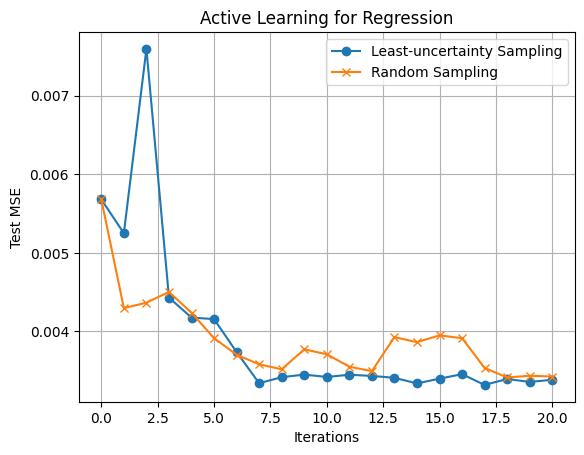

Test MSE for lc: 0.00338290853038309,  rand: 0.0034247895281054046 


In [39]:
#Implement the active-learning pipeline for regression to estimate the weight of fish.

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100,max_depth=5, random_state = general_seed)
#Set the number of samples to take from the unlabelled pool and the itterations for the active learning proces
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all_reg.shape[0]*sample_factor)

#Perform active learning using different sampling methods: least-certainty, diversity, mix of both and random
test_mse_lc_reg, train_data_lc_reg,_ = run_al_reg(get_unc_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)
test_mse_rand_reg, train_data_rand_reg,_ = run_random_reg(rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)

#Plot the Predicted Weight and the true one with the active learning methods
plt.plot(range(N+1),test_mse_lc_reg,  marker='o' )
plt.plot(range(N+1), test_mse_rand_reg, marker='x')
plt.xlabel('Iterations')
plt.ylabel('Test MSE')
plt.title('Active Learning for Regression')
plt.legend(['Least-uncertainty Sampling',"Random Sampling"])
plt.grid()
plt.show()

#Calculate the MSE at the end of the active learning
test_mse_lc = al_train_and_test_reg(rf, train_data_lc_reg, test_data_all_reg)
test_mse_rand = al_train_and_test_reg(rf, train_data_rand_reg, test_data_all_reg)

print("Test MSE for lc: {},  rand: {} ".format(test_mse_lc, test_mse_rand ))

## 5.2 Compare different sampling methods

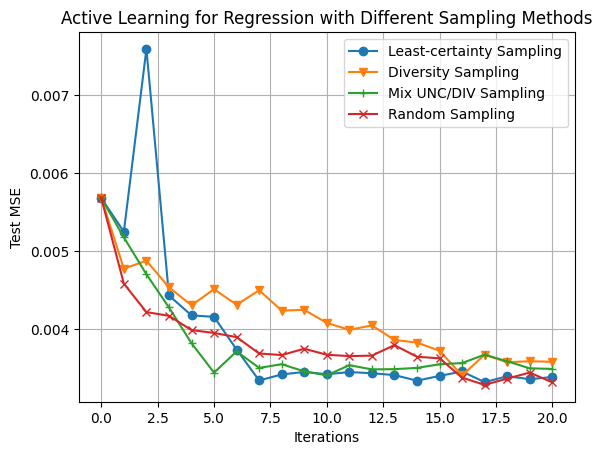

Test MSE for lc: 0.00338290853038309, div: 0.0035790574118906866, mix: 0.00348768367756525, rand: 0.0033146071699775145 


In [40]:
#• Compare four methods: (1) uncertainty sampling, (2) diversity sampling, (3) a mix of uncertainty
#and diversity sampling, and (4) random sampling.
#Perform active learning using different sampling methods: least-certainty, diversity, mix of both and random
test_mse_lc_reg,  train_data_lc_reg,_ = run_al_reg(get_unc_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)
test_mse_div_reg, train_data_div_reg,_ = run_al_reg(get_div_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)
test_mse_mix_reg, train_data_mix_reg,_ = run_al_reg(get_unc_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N, mix = True)
test_mse_rand_reg, train_data_rand_reg,_ = run_random_reg(rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)

#Plot the MSES of the different active learning methods
plt.plot(range(N+1), test_mse_lc_reg,marker='o')
plt.plot(range(N+1), test_mse_div_reg,marker='v')
plt.plot(range(N+1),  test_mse_mix_reg,marker='+' )
plt.plot(range(N+1),  test_mse_rand_reg,marker='x')


plt.xlabel('Iterations')
plt.ylabel('Test MSE')
plt.title('Active Learning for Regression with Different Sampling Methods')
plt.legend(['Least-certainty Sampling',"Diversity Sampling","Mix UNC/DIV Sampling", "Random Sampling"])
plt.grid()
plt.show()

test_mse_lc = al_train_and_test_reg(rf, train_data_lc_reg, test_data_all_reg)
test_mse_div = al_train_and_test_reg(rf, train_data_div_reg, test_data_all_reg)
test_mse_mix = al_train_and_test_reg(rf, train_data_mix_reg, test_data_all_reg)
test_mse_rand = al_train_and_test_reg(rf, train_data_rand_reg, test_data_all_reg)

print("Test MSE for lc: {}, div: {}, mix: {}, rand: {} ".format(test_mse_lc, test_mse_div, test_mse_mix, test_mse_rand ))

## 5.3 Try all fish species

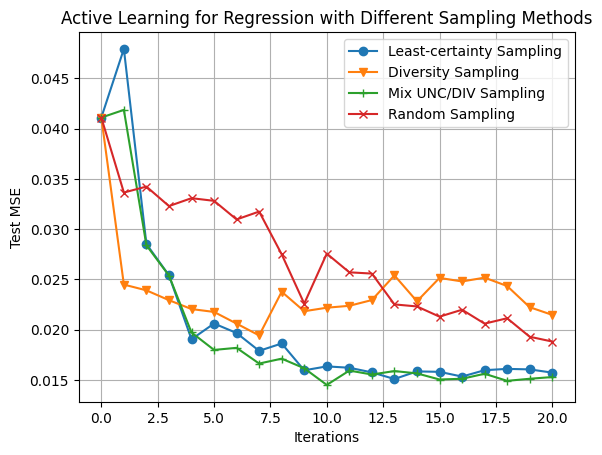

Test MSE for lc: 0.01572917997184847, div: 0.021475664858291874, mix: 0.015288737325001514, rand: 0.01882256313316615 


In [41]:
#Now try with all fish species
train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg = al_split_data(pd_all_features, train_size= 0.01, test_size=0.20)
dev_data_reg=pd.concat([train_data_all_reg,unlabelled_data_all_reg],axis=0)

#• Compare four methods: (1) uncertainty sampling, (2) diversity sampling, (3) a mix of uncertainty
#and diversity sampling, and (4) random sampling.

#Perform active learning using different sampling methods: least-certainty, diversity, mix of both and random
test_mse_lc_reg,  train_data_lc_reg,_ = run_al_reg(get_unc_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)
test_mse_div_reg, train_data_div_reg,_ = run_al_reg(get_div_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)
test_mse_mix_reg, train_data_mix_reg,_ = run_al_reg(get_unc_rf, rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N, mix = True)
test_mse_rand_reg, train_data_rand_reg,_ = run_random_reg(rf, train_data_all_reg, unlabelled_data_all_reg, test_data_all_reg, n_samples, N)

#Plot the MSES of the different active learning methods
plt.plot(range(N+1),test_mse_lc_reg,marker='o')
plt.plot(range(N+1), test_mse_div_reg,marker='v')
plt.plot(range(N+1),  test_mse_mix_reg,marker='+')
plt.plot(range(N+1),  test_mse_rand_reg,marker='x')


plt.xlabel('Iterations')
plt.ylabel('Test MSE')
plt.title('Active Learning for Regression with Different Sampling Methods')
plt.legend(['Least-certainty Sampling',"Diversity Sampling","Mix UNC/DIV Sampling", "Random Sampling"])
plt.grid()
plt.show()

test_mse_lc = al_train_and_test_reg(rf, train_data_lc_reg, test_data_all_reg)
test_mse_div = al_train_and_test_reg(rf, train_data_div_reg, test_data_all_reg)
test_mse_mix = al_train_and_test_reg(rf, train_data_mix_reg, test_data_all_reg)
test_mse_rand = al_train_and_test_reg(rf, train_data_rand_reg, test_data_all_reg)

print("Test MSE for lc: {}, div: {}, mix: {}, rand: {} ".format(test_mse_lc, test_mse_div, test_mse_mix, test_mse_rand ))

# Part 6: Open-set Recognition (bonus)

## 6.1 Prepare the data

In [42]:
#Step 1 Split the data into a dataset of 3 known species and 6 unknown species
# Identify the unique species in the dataset
unique_species = pd_all_features['species'].unique()

# Randomly select 3 species as known species
np.random.seed(general_seed)  # For reproducibility
known_species = np.random.choice(unique_species, size=3, replace=False)
unknown_species = [species for species in unique_species if species not in known_species]

# Split the data into known and unknown species
known_data = pd_all_features[pd_all_features['species'].isin(known_species)]
unknown_data = pd_all_features[pd_all_features['species'].isin(unknown_species)]
#Split the known data into training and unlabelled data
train_data, test_known_data = train_test_split(known_data, test_size=0.3, random_state=general_seed, stratify=known_data['species'])
test_data = pd.concat([test_known_data, unknown_data])

## 6.2 Implementation of OSNN and OSNN-CV

In [43]:
#Step 2: Implement and compare the effectiveness of OSNN and OSNN-CV methods

#Define OSNN_CV function that trains a nearest neighbors clasifier on known data and checks with it
#if the two nearest neighbors belong to different species to classify a sample as unknown.
def OSNN_CV( known_data,test_data):
    X_known, y_known = get_features(known_data), get_label(known_data) #Get the known features and labels
    X_test, y_test = get_features(test_data), get_label(test_data) #Get the unknown features and labels
    clf = KNeighborsClassifier(n_neighbors = 5) #create the classifier
    clf.fit(X_known,y_known) #Train the classifier
    prediction = [] #Prepare a list to fill with the result of known unknown check
    dist, idx = clf.kneighbors(X_test) #Get the distances and index to all neighbors
    for i in range(len(test_data)):
        nearest_species_1 = y_known.iloc[idx[i][0]] #Get the nearest neighbor label
        nearest_species_2 = y_known.iloc[idx[i][1]] #Get the second nearest neighbor label

        # Check if the two nearest neighbors belong to different species
        if nearest_species_1 != nearest_species_2:
            prediction.append('unknown')
        else:
            # unknown.append(False)
            # If the two nearest neighbors belong to the same species, use knn to predict
            prediction.append(clf.predict([X_test.iloc[i]])[0])
    return prediction

#Define OSNN_CV function that trains a KNN clasifier on known data and checks with it
#if the two nearest neighbors of different classes have a distance ratio above a threshold
def OSNN(known_data,test_data, threshold = 0.5):
    X_known, y_known = get_features(known_data), get_label(known_data) #Get the known features and labels
    X_test, y_test = get_features(test_data), get_label(test_data) #Get the unknown features and labels
    clf = KNeighborsClassifier(n_neighbors = 5) #create the classifier
    clf.fit(X_known,y_known) #Train the classifier
    prediction = [] #Prepare a list to fill with the result of known unknown check
    dist, idx = clf.kneighbors(X_test, n_neighbors=20) #Get the distances and index to the all neighbors

    for i in range(len(test_data)):
        nearest_species = [y_known.iloc[j] for j in idx[i]]
        nearest_distances = dist[i]
        # Initialize distance ratio to 0
        dist_ratio = 0
        for j in range(10):
            for k in range(j + 1, 10):
                if nearest_species[j] != nearest_species[k]:

                    dist_ratio = nearest_distances[j] / nearest_distances[k]
                    break
            if dist_ratio > 0:
                break

        # Check if the ratio exceeds the threshold
        #print(dist_ratio)
        if dist_ratio > threshold:
            prediction.append('unknown')
        else:
            prediction.append(clf.predict([X_test.iloc[i]])[0])
    return prediction

result_osnn = OSNN(train_data,test_data, 0.8)
result_osnn_cv = OSNN_CV(train_data, test_data)

In [44]:
test_data_labels=get_label(test_data)
#if value is not in known_species, then replace it with ‘unknown’
test_data_labels = test_data_labels.apply(lambda x: x if x in known_species else 'unknown')

In [45]:
# make sure that the prediction result and the test data labels have the same set of classes
#unique values in result_osnn
print("OSNN: ", np.unique(result_osnn))
# convert the data type to string
test_data_labels=test_data_labels.astype(str)
#unique values in test_data_labels
print("test_data_labels: ", np.unique(test_data_labels))

OSNN:  ['2.0' '7.0' '8.0' 'unknown']
test_data_labels:  ['2.0' '7.0' '8.0' 'unknown']


## 6.3 Comparison between OSNN and OSNN-CV

In [46]:
# classification report
print("OSNN classification report \n",classification_report(test_data_labels, result_osnn))
# classification report
print("OSNN-CV classification report \n",classification_report(test_data_labels, result_osnn_cv))

OSNN classification report 
               precision    recall  f1-score   support

         2.0       0.02      1.00      0.04        18
         7.0       0.12      1.00      0.22        26
         8.0       1.00      0.78      0.88         9
     unknown       1.00      0.48      0.65      2040

    accuracy                           0.49      2093
   macro avg       0.54      0.81      0.45      2093
weighted avg       0.98      0.49      0.64      2093

OSNN-CV classification report 
               precision    recall  f1-score   support

         2.0       0.01      1.00      0.02        18
         7.0       0.07      1.00      0.13        26
         8.0       0.89      0.89      0.89         9
     unknown       1.00      0.14      0.24      2040

    accuracy                           0.16      2093
   macro avg       0.49      0.76      0.32      2093
weighted avg       0.98      0.16      0.24      2093



## 6.4 Effect of the threshold in OSNN

Iteration progress: 0 in 9
Iteration progress: 1 in 9
Iteration progress: 2 in 9
Iteration progress: 3 in 9
Iteration progress: 4 in 9
Iteration progress: 5 in 9
Iteration progress: 6 in 9
Iteration progress: 7 in 9
Iteration progress: 8 in 9


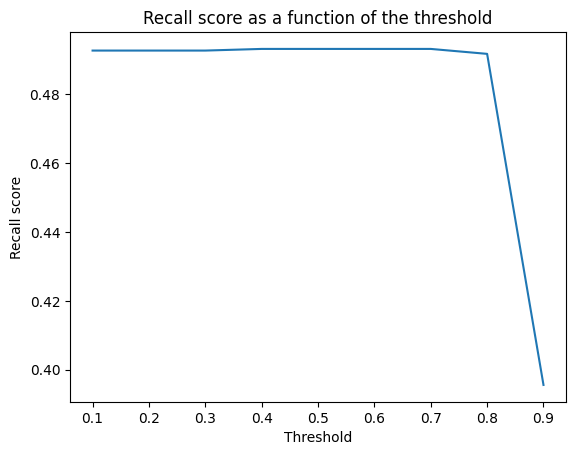

In [47]:
# study the effect of the threshold on the performance of the OSNN method
thresholds = np.linspace(0.1, 0.9, 9)
recall_score_list = []
counter=0
for threshold in thresholds:
    print(f"Iteration progress: {counter} in {len(thresholds)}")
    result_osnn = OSNN(train_data,test_data, threshold)
    recall_score_list.append(recall_score(test_data_labels, result_osnn, average='micro'))
    counter+=1
# plot the recall score as a function of the threshold
plt.plot(thresholds, recall_score_list)
plt.xlabel('Threshold')
plt.ylabel('Recall score')
plt.title('Recall score as a function of the threshold')
plt.show()

# Appendix

## Environment Info

Package                       Version
----------------------------- -----------
absl-py                       1.3.0
agate                         1.6.3
alembic                       1.11.1
altair                        4.2.2
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asn1crypto                    1.5.1
asttokens                     2.0.8
astunparse                    1.6.3
attrs                         22.1.0
Automat                       20.2.0
Babel                         2.10.3
backcall                      0.2.0
bcrypt                        4.0.1
beautifulsoup4                4.11.1
bleach                        5.0.1
blis                          0.7.9
boto3                         1.34.60
botocore                      1.34.60
branca                        0.5.0
cachetools                    5.2.0
catalogue                     2.0.8
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.1.1
click                         8.1.3
click-plugins                 1.1.1
clickhouse-driver             0.2.4
clickhouse-sqlalchemy         0.2.2
cligj                         0.7.2
confection                    0.0.3
constantly                    15.1.0
contourpy                     1.0.5
cryptography                  36.0.2
cssselect                     1.1.0
cycler                        0.11.0
cymem                         2.0.7
datascience                   0.17.5
db-dtypes                     1.2.0
debugpy                       1.6.3
decorator                     5.1.1
defusedxml                    0.7.1
dill                          0.3.5.1
dnspython                     2.2.1
duckdb                        0.9.2
duckdb-engine                 0.7.0
entrypoints                   0.4
executing                     1.1.1
fastjsonschema                2.16.2
filelock                      3.8.0
Fiona                         1.8.22
flatbuffers                   22.9.24
folium                        0.13.0
fonttools                     4.37.4
fsspec                        2024.2.0
future                        0.18.2
gast                          0.4.0
geopandas                     0.11.1
google-api-core               2.11.1
google-auth                   2.21.0
google-auth-oauthlib          0.4.6
google-cloud-bigquery         3.19.0
google-cloud-bigquery-storage 2.16.2
google-cloud-core             2.3.2
google-cloud-spanner          3.36.0
google-crc32c                 1.5.0
google-pasta                  0.2.0
google-resumable-media        2.4.0
googleapis-common-protos      1.56.4
greenlet                      1.1.3.post0
grpc-google-iam-v1            0.12.6
grpcio                        1.50.0
grpcio-status                 1.48.2
h5py                          3.7.0
hyperlink                     21.0.0
idna                          3.4
incremental                   22.10.0
ipykernel                     6.16.1
ipython                       8.5.0
ipython-genutils              0.2.0
isodate                       0.6.1
itemadapter                   0.7.0
itemloaders                   1.0.6
jedi                          0.17.2
Jinja2                        3.1.2
jmespath                      1.0.1
joblib                        1.2.0
jsonify                       0.5
jsonschema                    3.2.0
jupyter_client                7.4.3
jupyter_core                  4.11.2
jupyter-server                1.21.0
jupyterlab-pygments           0.2.2
keras                         2.10.0
Keras-Preprocessing           1.1.2
kiwisolver                    1.4.4
langcodes                     3.3.0
leather                       0.3.4
libclang                      14.0.6
llvmlite                      0.43.0
lxml                          4.9.1
Mako                          1.2.4
Markdown                      3.4.1
MarkupSafe                    2.0.0
matplotlib                    3.6.0
matplotlib-inline             0.1.6
mistune                       0.8.4
mpmath                        1.2.1
munch                         2.5.0
murmurhash                    1.0.9
nbclassic                     1.0.0
nbclient                      0.5.13
nbconvert                     6.4.5
nbformat                      5.7.0
nest-asyncio                  1.5.6
nltk                          3.7
notebook                      6.5.5
notebook_shim                 0.2.3
numba                         0.60.0
numpy                         1.23.4
oauthlib                      3.2.2
opt-einsum                    3.3.0
oscrypto                      1.3.0
packaging                     21.3
pandas                        2.1.4
pandocfilters                 1.5.0
paramiko                      3.0.0
parsedatetime                 2.4
parsel                        1.6.0
parso                         0.7.1
pathy                         0.6.2
pexpect                       4.8.0
pg8000                        1.29.6
pickleshare                   0.7.5
Pillow                        9.2.0
pip                           23.0.1
plotly                        5.20.0
pluggy                        1.0.0
preshed                       3.0.8
prometheus-client             0.15.0
prompt-toolkit                3.0.31
Protego                       0.2.1
proto-plus                    1.22.1
protobuf                      3.19.6
psutil                        5.9.3
psycopg2-binary               2.9.4
ptyprocess                    0.7.0
pure-eval                     0.2.2
pyarrow                       9.0.0
pyasn1                        0.4.8
pyasn1-modules                0.2.8
PyAthena                      3.1.0
pycparser                     2.21
pycryptodomex                 3.15.0
pydantic                      1.10.2
PyDispatcher                  2.0.6
Pygments                      2.13.0
PyJWT                         2.6.0
pymongo                       4.3.2
pymssql                       2.2.5
PyMySQL                       1.0.2
PyNaCl                        1.5.0
pynndescent                   0.5.13
pyOpenSSL                     22.0.0
pyparsing                     3.0.9
pyproj                        3.4.0
pyrsistent                    0.18.1
python-dateutil               2.8.2
python-jsonrpc-server         0.4.0
python-language-server        0.5
python-slugify                6.1.2
pytimeparse                   1.1.8
pytz                          2022.5
pytz-deprecation-shim         0.1.0.post0
pyzmq                         24.0.1
queuelib                      1.6.2
regex                         2022.9.13
requests                      2.28.1
requests-file                 1.5.1
requests-oauthlib             1.3.1
rsa                           4.9
s3transfer                    0.10.0
scikit-learn                  1.1.2
scipy                         1.9.3
scramp                        1.4.4
Scrapy                        2.7.0
seaborn                       0.13.2
Send2Trash                    1.8.0
sentry-sdk                    1.24.0
service-identity              21.1.0
setuptools                    65.5.0
Shapely                       1.8.5.post1
six                           1.16.0
smart-open                    5.2.1
sniffio                       1.3.0
snowflake-connector-python    2.8.0
snowflake-sqlalchemy          1.4.3
soupsieve                     2.3.2.post1
spacy                         3.4.2
spacy-legacy                  3.0.10
spacy-loggers                 1.0.3
sql-metadata                  2.6.0
SQLAlchemy                    1.4.42
sqlalchemy-bigquery           1.6.1
sqlalchemy-dremio             3.0.3
sqlalchemy-redshift           0.8.11
sqlalchemy-spanner            1.6.2
sqlparse                      0.4.3
squarify                      0.4.3
srsly                         2.4.5
sshtunnel                     0.4.0
stack-data                    0.5.1
sympy                         1.11.1
tabulate                      0.9.0
tenacity                      8.1.0
tensorboard                   2.10.1
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.1
tensorflow                    2.10.0
tensorflow-estimator          2.10.0
tensorflow-io-gcs-filesystem  0.27.0
termcolor                     2.0.1
terminado                     0.16.0
testpath                      0.6.0
text-unidecode                1.3
textblob                      0.17.1
thinc                         8.1.5
threadpoolctl                 3.1.0
tldextract                    3.4.0
toolz                         0.12.0
torch                         1.12.1
torchvision                   0.13.1
tornado                       6.2
tqdm                          4.64.1
traitlets                     5.5.0
trino                         0.322.0
Twisted                       22.8.0
typer                         0.4.2
typing_extensions             4.4.0
tzdata                        2022.5
tzlocal                       4.2
ujson                         5.5.0
umap-learn                    0.5.6
urllib3                       1.26.12
w3lib                         2.0.1
wasabi                        0.10.1
wcwidth                       0.2.5
webencodings                  0.5.1
websocket-client              1.4.1
Werkzeug                      2.2.2
wheel                         0.40.0
wrapt                         1.14.1
zope.interface                5.5.0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a014df4-72ec-4c41-add8-12241dad5fbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>